In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# from sklearn.preprocessing import FunctionTransformer
sns.set()

In [2]:
data = pd.read_csv("./AI_Human.csv")
df = data.copy()
print(df.shape)
df.head()

(487235, 2)


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [3]:
df["generated"] = df["generated"].astype(int)
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [13]:
df.dropna(inplace=True)

In [14]:
df["generated"].value_counts()

generated
0    305797
1    181438
Name: count, dtype: int64

In [ ]:
np.random.shuffle()

In [20]:
def select_random_data(data, size):
    length = data.shape[0]
    selections = np.random.choice(np.arange(length), size=size, replace=False)
    df = data.iloc[selections]
    df["generated"] = df["generated"].astype(int)
    return df

In [26]:
# df.iloc[np.random.choice(np.arange(1000), size=50, replace=False)]
trimmed_data1 = select_random_data(data[df["generated"] == 0], 150_000)
trimmed_data2 = select_random_data(data[df["generated"] == 1], 150_000)
trimmed_data = pd.concat([trimmed_data1, trimmed_data2], axis=0).reset_index(drop=True)
shuffled_index = np.random.choice(np.arange(trimmed_data.shape[0]), trimmed_data.shape[0], replace=False)
# print(shuffled_index)
trimmed_data = trimmed_data.iloc[shuffled_index].reset_index(drop=True)
print(trimmed_data.shape)
trimmed_data

(300000, 2)


/var/folders/1_/j2g7glf17mz0hz43m2fqsc4h0000gn/T/ipykernel_46703/3022281107.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["generated"] = df["generated"].astype(int)
/var/folders/1_/j2g7glf17mz0hz43m2fqsc4h0000gn/T/ipykernel_46703/3022281107.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["generated"] = df["generated"].astype(int)


,text,generated
0,"As an exghthgrade student, I have set a goal f...",1
1,Some schools think that students should attend...,0
2,There are many advantages to listing car usage...,0
3,"Thomas Jefferson once said, ""I have not failed...",1
4,"Hey there, it's me, an average 8th grade stude...",1
...,...,...
299995,Technology should be allowed to read other stu...,0
299996,"Hey, so like, I totally have to write this ess...",1
299997,What would life without cars be like? Cities t...,0
299998,"In the article, ""Making Mona Lina Smile"", I le...",0


In [27]:
trimmed_data.isna().sum()

text         0
generated    0
dtype: int64

In [33]:
trimmed_data.iloc[:, 0]

0         As an exghthgrade student, I have set a goal f...
1         Some schools think that students should attend...
2         There are many advantages to listing car usage...
3         Thomas Jefferson once said, "I have not failed...
4         Hey there, it's me, an average 8th grade stude...
                                ...                        
299995    Technology should be allowed to read other stu...
299996    Hey, so like, I totally have to write this ess...
299997    What would life without cars be like? Cities t...
299998    In the article, "Making Mona Lina Smile", I le...
299999    It is a common belief that young people enjoy ...
Name: text, Length: 300000, dtype: object

In [34]:
X = trimmed_data.iloc[:, 0]
y = trimmed_data["generated"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [ ]:
vectorizer = CountVectorizer(stop_words="english", max_df=.8, min_df=3)

In [ ]:
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


class Models:
    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.punctuations = string.punctuation + "0123456789"
        self.clf = None
        # self.train = pd.read_csv(r"data/Poem_classification_train_data.csv")
        # self.train.dropna(inplace=True)
        # self.test = pd.read_csv(r"data/Poem_classification_test_data.csv")
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.pred = None
        self.model = model

        
    def model_init(self):
        if self.model == "random forest":
            self.clf = make_pipeline(FunctionTransformer(self.remove_punctuations), CountVectorizer(stop_words="english"), RandomForestClassifier(random_state=42))
        elif self.model == "svm":
            self.clf = make_pipeline(FunctionTransformer(self.remove_punctuations), CountVectorizer(stop_words="english"), SVC(random_state=42))
        elif self.model == "xgboost":
            # self.clf = make_pipeline(FunctionTransformer(self.remove_punctuations), CountVectorizer(stop_words="english"), XGBClassifier())
            self.clf = make_pipeline(CountVectorizer(stop_words="english"), XGBClassifier())
        elif self.model == "decision tree":
            self.clf = make_pipeline(FunctionTransformer(self.remove_punctuations), CountVectorizer(stop_words="english"), DecisionTreeClassifier(random_state=42))
        elif self.model == "naive bayes multinomial":
            self.clf = make_pipeline(FunctionTransformer(self.remove_punctuations), CountVectorizer(stop_words="english"), MultinomialNB())
        elif self.model == "naive bayes complement":
            self.clf = make_pipeline(FunctionTransformer(self.remove_punctuations), CountVectorizer(stop_words="english"), ComplementNB())
        elif self.model == "knn":
            self.clf = make_pipeline(FunctionTransformer(self.remove_punctuations), CountVectorizer(stop_words="english"), KNeighborsClassifier())
        if self.model != "xgboost":
            self.clf.fit(self.X_train, self.y_train)
        else:
            self.clf.fit(self.X_train, self.xg_boost()[0])
        # print(f"{type(self.clf) = }")

    def xg_boost(self):
        le = LabelEncoder()
        y_train_lr = le.fit_transform(self.y_train)
        y_test_lr = le.transform(self.y_test)
        classes = le.classes_
        # print(f"{classes = }")
        return y_train_lr, y_test_lr, classes

    def metrics(self):
        self.pred = self.clf.predict(self.X_test)
        classes = self.clf.classes_
        if self.model == "xgboost":
            class_report = pd.DataFrame(classification_report(self.xg_boost()[1], self.pred, target_names=self.xg_boost()[2], output_dict=True)).transpose()
        else:
            class_report = pd.DataFrame(classification_report(self.y_test, self.pred, target_names=classes, output_dict=True)).transpose()
        return class_report

    def remove_punctuations(self, series):
        res = []
        for _ in series:
            res.append("".join([char for char in _ if char not in self.punctuations]))
        return res

    def save_fig(self):
        if self.model == "xgboost":
            cm = confusion_matrix(self.xg_boost()[1], self.pred)
            display = ConfusionMatrixDisplay(cm, display_labels=self.xg_boost()[2]).plot()
        else:
            cm = confusion_matrix(self.y_test, self.pred)
            display = ConfusionMatrixDisplay(cm, display_labels=self.clf.classes_).plot()
        plt.savefig("temp.png")

    def final_result(self):
        self.model_init()
        self.metrics()
        self.save_fig()

In [39]:
m = Models("xgboost", X_train, y_train, X_test, y_test)

classes = array([0, 1])
classes = array([0, 1])
classes = array([0, 1])
classes = array([0, 1])
classes = array([0, 1])


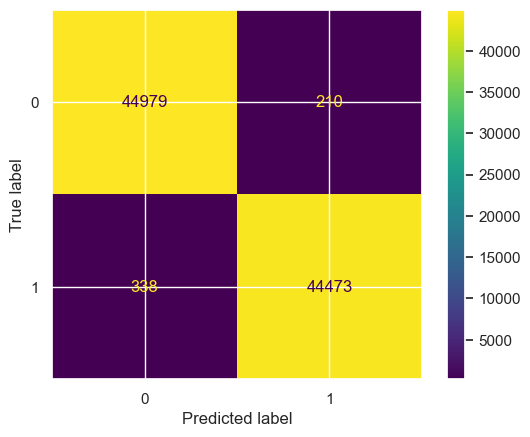

In [40]:
m.final_result()